# Ejercicio 6: GDA (Gaussian Discriminant Analysis)


---
Implementen su propia versión de un modelo GDA sobre el mismo dataset que el punto anterior y compare sus resultados. ¿Que modelo dió mejor accuracy? ¿Que similitudes o diferencias encuentran en los parámetros obtenidos? ¿Es posible sacar alguna conclusión de estos resultados?

## 1. Importación de librerías
Importación de librerías necesarias para manipulación de datos, visualización, balanceo de clases y métricas.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


## 2. Definición de la clase GDA

Implementación desde cero del modelo GDA, con métodos para entrenar (`fit`), predecir (`predict`) y calcular precisión (`score`).

In [ ]:
class GDA:
    def __init__(self):
        self.clases = None
        self.mu = {}           # Medias por clase
        self.sigma = {}        # Matrices de covarianza por clase
        self.priors = {}       # Probabilidades a priori por clase

    def fit(self, X, y):
        """Entrena el modelo GDA calculando medias, covarianzas y priors."""
        self.clases = np.unique(y)

        for clase in self.clases:
            X_clase = X[y == clase]
            self.mu[clase] = np.mean(X_clase, axis=0)           # Calcula la media por clase
            self.sigma[clase] = np.cov(X_clase, rowvar=False)   # Calcula la matriz de covarianza por clase
            self.priors[clase] = len(X_clase) / len(X)          # Calcula la probabilidad a priori por clase

    def predict(self, X):
        """Predice la clase para cada muestra en X."""
        predicciones = []
        d = X.shape[1]  # Número de características (dimensiones)

        for x in X:
            probabilidades = {}

            for clase in self.clases:
                mu = self.mu[clase]
                sigma = self.sigma[clase]

                # Inversa de la matriz de covarianza (usa pinv si no es invertible)
                try:
                    inv_sigma = np.linalg.inv(sigma)
                except np.linalg.LinAlgError:
                    inv_sigma = np.linalg.pinv(sigma)

                # Determinante seguro para evitar división por cero
                det_sigma = np.linalg.det(sigma)
                if det_sigma == 0:
                    det_sigma = 1e-10 # Evita la division por 0

                diff = x - mu   # Diferencia entre muestra y media
                exponente = -0.5 * (diff @ inv_sigma @ diff.T)  # Exponente de la Gaussiana
                norm_factor = 1 / np.sqrt((2 * np.pi) ** d * det_sigma)   # Factor de normalización

                prob_conjunta = norm_factor * np.exp(exponente)   # Probabilidad conjunta P(x|y) * P(y)
                probabilidades[clase] = self.priors[clase] * prob_conjunta

            # Seleccionar clase con mayor probabilidad
            predicciones.append(max(probabilidades, key=probabilidades.get))

        return np.array(predicciones)

    def score(self, X, y):
        """Calcula la precisión del modelo en datos dados."""
        y_pred = self.predict(X)
        return np.mean(y_pred == y)   # Porcentaje de aciertos


## 3. Carga y preprocesamiento del dataset

Carga del dataset, eliminación de nulos, conversión de etiquetas a numéricas, balanceo de las clases y división de los datos en entrenamiento y prueba.



In [ ]:
# Cargargamos el dataset
df = pd.read_csv('dataset.csv')
df = df.dropna()    # Elimina filas con valores nulos

# Separaramos features y labels


X = df.drop(columns=['label'])
y = df['label'].map({"'Male'": 0, "'Female'": 1}) # Convertir a valores numericos

# Resample para balancear las clases
X_resampled, y_resampled = RandomOverSampler(random_state=42).fit_resample(X, y)

# Dividisión de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,test_size=0.2, random_state=42)

# Entrenar y evaluar GDA
gda = GDA()
gda.fit(X_train.to_numpy(), y_train.to_numpy())
y_pred_gda = gda.predict(X_test.to_numpy())
print('Precisión de GDA:', gda.score(X_test.to_numpy(), y_test.to_numpy()))



Precisión de GDA: 0.795


## 4. Matriz de confusión GDA

Visualición de la matriz de confusión GDA para evaluar su desempeño.

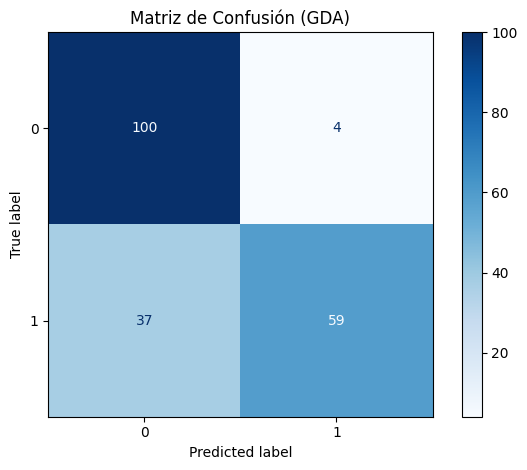

In [ ]:
# Calcular matrices de confusión
cm_gda = confusion_matrix(y_test, y_pred_gda)

# disp_gda = ConfusionMatrixDisplay(confusion_matrix=cm_gda, display_labels=gda.clases)
disp_gda = ConfusionMatrixDisplay(confusion_matrix=cm_gda)
disp_gda.plot( cmap=plt.cm.Blues)
plt.title('Matriz de Confusión (GDA)')

plt.tight_layout()
plt.show()

## 5. Explicación teórica multicolinealidad

La multicolinealidad es cuando varias variables del dataset están muy relacionadas entre sí, lo que puede causar problemas en algunos modelos. En el caso de GDA, esto es un problema porque el modelo necesita calcular una matriz de covarianza para cada clase, y si las variables están muy correlacionadas, esas matrices pueden volverse difíciles de invertir o inestables. Por eso, el rendimiento de GDA baja cuando hay multicolinealidad. En cambio, LDA usa una sola matriz de covarianza para todas las clases, lo que lo hace más resistente a este problema y suele funcionar mejor cuando hay muchas variables correlacionadas. Por eso, en este ejercicio, LDA dio mejores resultados que GDA.

## 6. Visualización de datos

Muestra las primeras filas del dataset para una exploración inicial.

In [ ]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,label
0,4168.540921,0.041952,-0.004120,-0.018341,0.013710,0.032051,0.198312,4.217751,4567.966833,0.007638,...,2.992955,13.365060,-21.423859,20.793436,-9.651550,-0.542568,2.074714,4.419655,-7.877144,'Male'
1,3720.553490,0.026697,-0.003738,-0.014786,0.006104,0.020889,0.202446,2.930900,4786.482802,0.006194,...,10.030447,13.517297,-18.716736,17.538837,-5.305826,3.498623,-5.981181,6.876701,-5.241452,'Male'
2,4350.384563,0.030334,-0.002243,-0.012039,0.006470,0.018509,-0.086239,27.558958,5168.495334,0.008030,...,12.070136,15.976955,-10.095880,17.772120,-0.530345,2.419048,-1.095302,3.073071,-1.433639,'Female'
3,5522.652557,0.030182,-0.002777,-0.006592,0.000595,0.007187,0.303947,10.862832,5641.428419,0.015523,...,10.555255,17.392838,-13.155245,13.167698,0.043060,12.459112,-8.451196,-0.185374,2.774778,'Female'
4,1932.357776,0.077988,-0.002838,-0.017960,0.004944,0.022903,0.787543,7.722107,2955.718782,0.000503,...,9.446449,18.787123,-2.199435,-2.855125,-0.149264,0.375201,-1.553188,0.901572,1.065513,'Male'


## 7. Mapa de calor de correlación

Visualización de la matriz de correlación entre variables para detectar multicolinealidad.

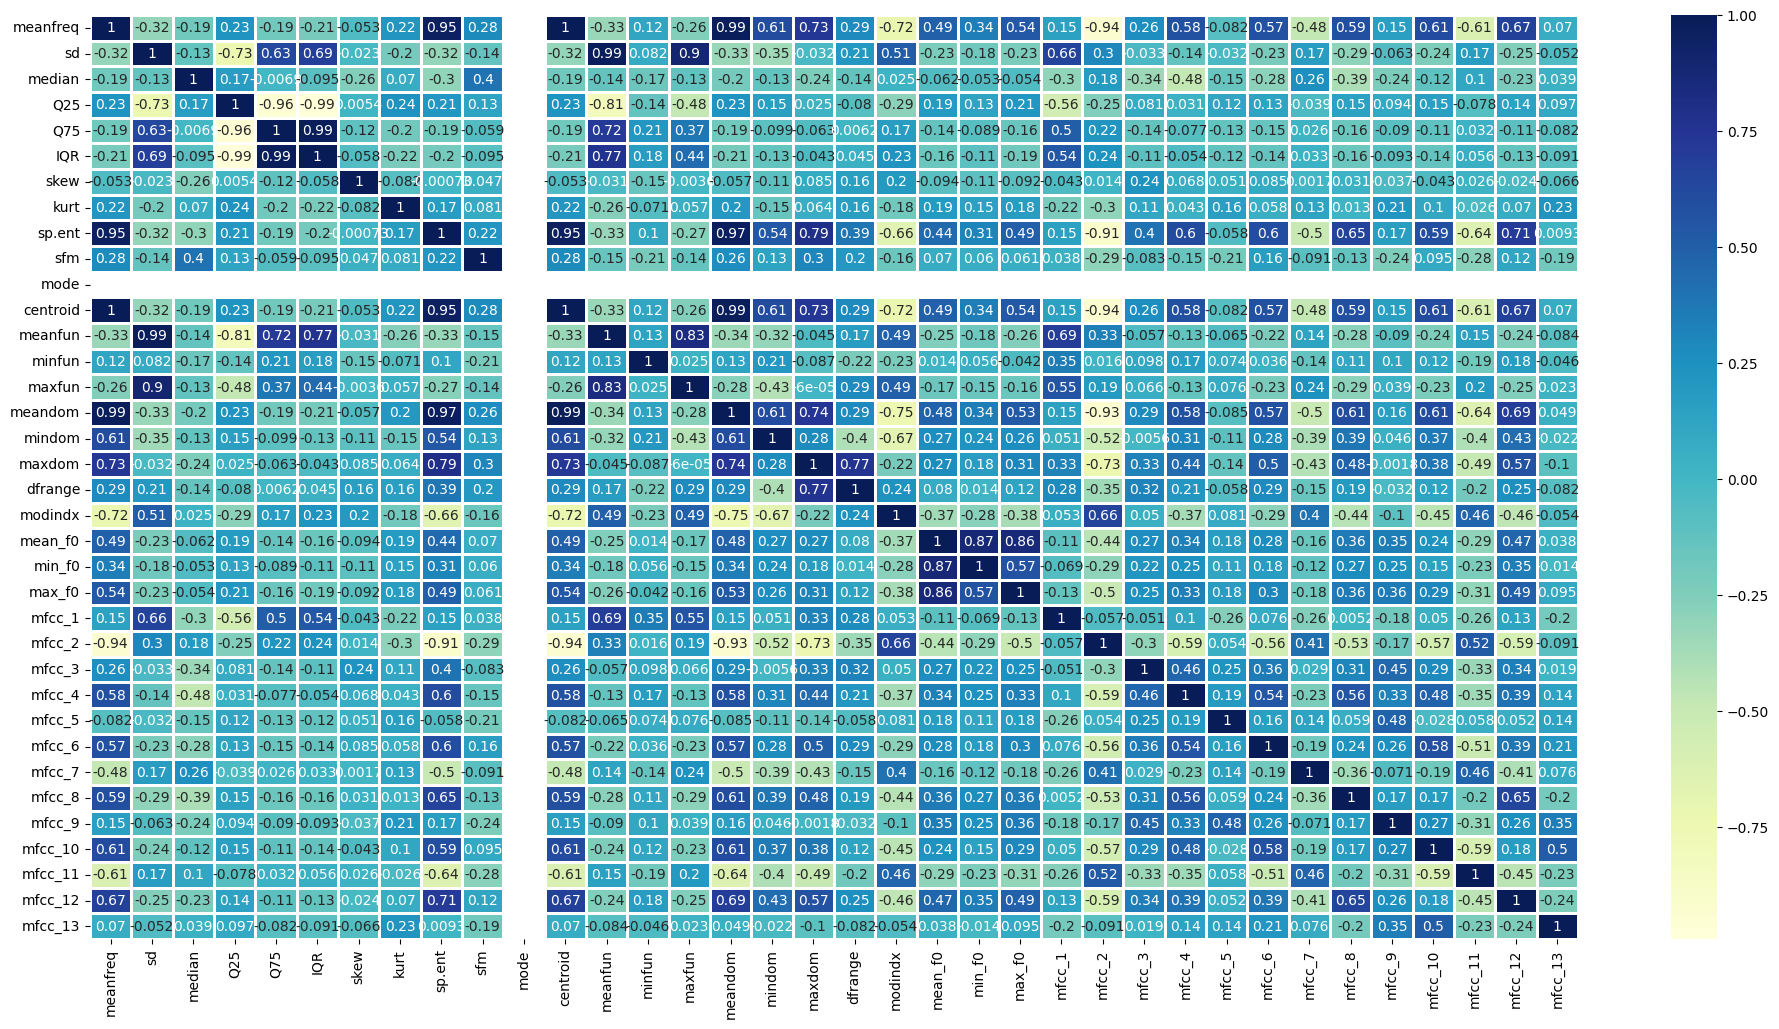

In [ ]:
# Calcular la matriz de correlación entre variables numéricas
corr = X.corr()

# Crear el mapa de calor para visualizar correlaciones
plt.figure(figsize=(24, 12))
sns.heatmap(corr, annot=True, linewidths=1, cmap='YlGnBu')
plt.show()

## 8. Eliminación de variables correlacionadas

Eliminación de variables con alta correlación (> 0.75) para reducir la multicolinealidad.

In [ ]:

# Calcular la matriz de correlación
corr_matrix = corr.abs()  # valores absolutos para comparar magnitudes

# Eliminar la diagonal (correlación consigo misma)
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Encontrar columnas con correlación > 0.75
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.75)]

# Eliminar esas columnas del DataFrame para reducir multicolinealidad
X_filtered = X.drop(columns=to_drop)

print('Columnas eliminadas por alta correlación (> 0.75):', to_drop)


Columnas eliminadas por alta correlación (> 0.75): ['Q75', 'IQR', 'sp.ent', 'centroid', 'meanfun', 'maxfun', 'meandom', 'maxdom', 'dfrange', 'min_f0', 'max_f0', 'mfcc_2']


## 9. Reentrenamiento y evaluación tras filtrado

Reentrena el modelo GDA con las variables filtradas y evalúa la precisión.

In [ ]:
X_resampled, y_resampled = RandomOverSampler(random_state=42).fit_resample(X_filtered, y)

# Dividir en entrenamiento y prueba con las variables filtradas
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,test_size=0.2, random_state=42)

# Entrenar y evaluar GDA nuevamente
gda = GDA()
gda.fit(X_train.to_numpy(), y_train.to_numpy())
y_pred_gda_filtred = gda.predict(X_test.to_numpy())
print('Precisión de GDA:', gda.score(X_test.to_numpy(), y_test.to_numpy()))


Precisión de GDA: 0.82


## 10. Matriz de confusión tras filtrado

Muestra la matriz de confusión después de eliminar variables correlacionadas.

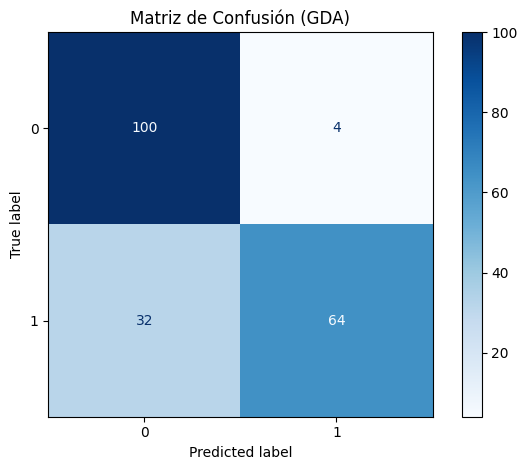

In [ ]:
# Calcular matrices de confusión
cm_gda = confusion_matrix(y_test, y_pred_gda_filtred)
disp_gda = ConfusionMatrixDisplay(confusion_matrix=cm_gda, display_labels=gda.clases)
disp_gda.plot( cmap=plt.cm.Blues)
plt.title('Matriz de Confusión (GDA)')

plt.tight_layout()
plt.show()

## 11. PCA (Principal Component Analysis) - Reducción de dimensionalidad

Aplicación de PCA para analizar la varianza explicada y confirmar la multicolinealidad.

In [ ]:
pca = PCA(n_components=0.95)  # Explica el 95% de la varianza
X_pca = pca.fit_transform(X_resampled)

## 12. Gráfico de varianza explicada por PCA

Grafico de la varianza explicada por los componentes principales.

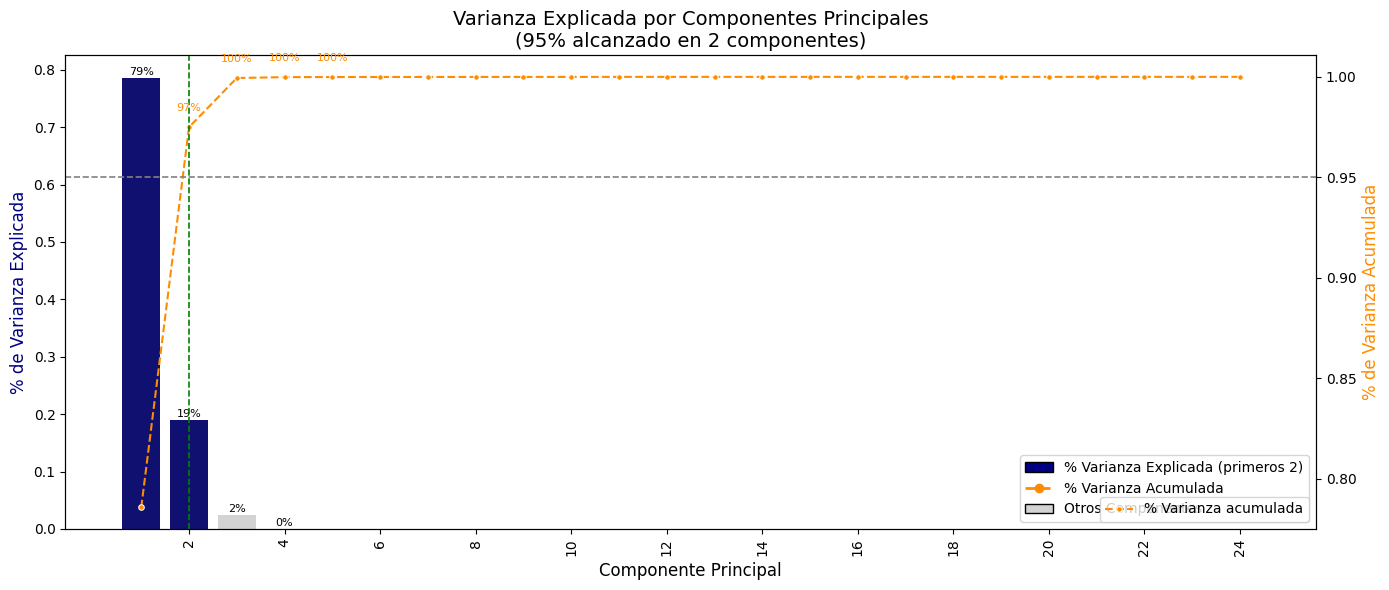

In [ ]:
pca = PCA()
pca.fit(X_resampled)

explained_variance = pca.explained_variance_ratio_
cum_explained_variance = np.cumsum(explained_variance)
x_range = np.arange(1, len(explained_variance) + 1)

fig, ax1 = plt.subplots(figsize=(14, 6))

# Barras para todos los componentes (suaves)
sns.barplot(x=x_range, y=explained_variance, color='lightgray', ax=ax1, zorder=1, label='Otros componentes')

# Resaltar los primeros 2 componentes
bar1 = sns.barplot(x=x_range[:2], y=explained_variance[:2], color='navy', ax=ax1, zorder=2, label='Primeros 5 componentes')

# Línea acumulada
ax2 = ax1.twinx()
line = sns.lineplot(x=x_range - 1, y=cum_explained_variance,
                    marker='o', markersize=4, linestyle='--', color='darkorange',
                    linewidth=1.5, ax=ax2, label='% Varianza acumulada')

# Etiquetas, líneas horizontales, etc. como antes...
threshold = 0.95
n_components_95 = np.argmax(cum_explained_variance >= threshold) + 1
ax2.axhline(y=threshold, color='gray', linestyle='--', linewidth=1.2)
ax2.axvline(x=n_components_95-1, color='green', linestyle='--', linewidth=1.2)

# Etiquetas en barras y línea (limitar a los primeros 4)
for i, v in enumerate(explained_variance[:4]):
    ax1.text(i, v + 0.005, f"{round(v * 100)}%", ha='center', fontsize=8, color='black')

for i, v in enumerate(cum_explained_variance):
    if 0 < i <= 4:
        ax2.text(i, v + 0.008, f"{round(v * 100)}%", ha='center', fontsize=8, color='darkorange')

# Leyendas personalizadas
legend_elements = [
    Patch(facecolor='navy', edgecolor='black', label='% Varianza Explicada (primeros 2)'),
    Line2D([0], [0], marker='o', color='darkorange', lw=2, linestyle='--', label='% Varianza Acumulada'),
    Patch(facecolor='lightgray', edgecolor='black', label='Otros Componentes')
]
ax1.legend(handles=legend_elements, loc='lower right')

# Ajuste final
ax1.set_xlabel('Componente Principal', fontsize=12)
ax1.set_ylabel('% de Varianza Explicada', fontsize=12, color='navy')
ax2.set_ylabel('% de Varianza Acumulada', fontsize=12, color='darkorange')
ax1.set_title(f'Varianza Explicada por Componentes Principales\n({threshold*100:.0f}% alcanzado en {n_components_95} componentes)', fontsize=14)

ax1.set_xticks(np.arange(1, 24, 2))  # Saltos para evitar saturación
ax1.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()


## 13. Conclusión

Después de eliminar las variables que tenían una correlación mayor a 0.75, el modelo GDA logró una precisión de **0.82** en el conjunto de prueba. Sin embargo, el análisis de PCA mostró que los primeros 2 componentes principales explican el **97%** de la varianza, lo que confirma que todavía hay mucha multicolinealidad en los datos.Con LDA ese modelo alcanzó un accuracy de **0.91**, superando a GDA. Por otro lado, GDA no funcionó bien porque la alta dependencia lineal entre las variables hizo que los parámetros fueran inestables y la precisión fuera baja. En resumen, LDA fue el que mejor resultado dio en este caso, mientras que GDA se vio afectado por la correlación entre las variables.